In [1]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

In [2]:
Nmics = 64
Nsamp = 200

src = (0, 0)

pitch = 0.1
dist_per_samp = 0.1
C = 2.0
SincP = 5.0

obstacle = (3, -1)

In [3]:
mics = []

# Ensure even number of mics
assert Nmics % 2 == 0, "Number of mics must be even!"

# Mics are symmetrically place about origin
for i in range(Nmics):
    mics.append((0, pitch * (-Nmics // 2 + 0.5 + i)))

In [4]:
# Maximum time - Nsamp * dist_per_samp / C
t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)
def wsrc(t):
    return np.sinc(SincP * t)

In [5]:
def dist(src: Tuple[float, float], pt: Tuple[float, float], mic: Tuple[float, float]) -> float:
    """Calculate the euclidean distance from src to pt to mic"""
    d1 = ((src[1] - pt[1]) ** 2 + (src[0] - pt[0]) ** 2) ** 0.5
    d2 = ((mic[1] - pt[1]) ** 2 + (mic[0] - pt[0]) ** 2) ** 0.5
    return d1 + d2

In [6]:
# Output captured by the mic
mic_output = np.zeros((Nmics, Nsamp))

for mic in range(Nmics):
    # Shift source output by time delay
    mic_output[mic] = wsrc(t - dist(src, obstacle, mics[mic]) / C)

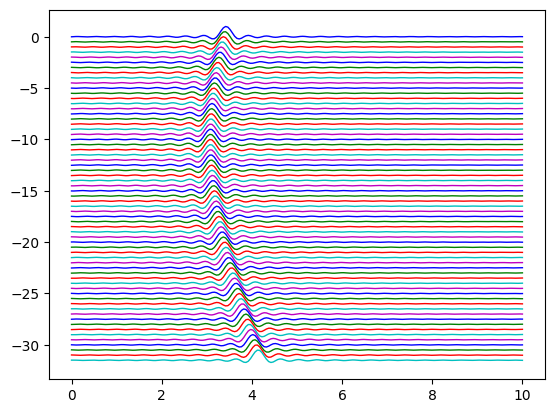

In [7]:
# Plotting the output
colors = "bgrcm"

for i in range(Nmics):
    plt.plot(t, mic_output[i] - 0.5 * i, c=colors[i % len(colors)], linewidth=1)

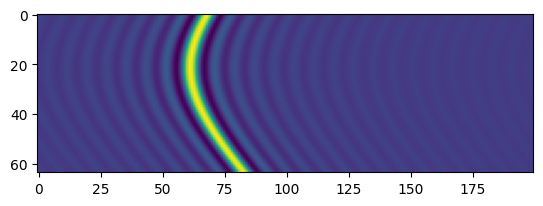

In [8]:
# Heatmap of time delays
plt.imshow(mic_output, cmap="viridis")

In [9]:
def sound_localisation(mic_output, dist_per_samp, pitch):
    """
    Given the output recorded by a microphone, return a matrix indicating the obstacles' position.
    This works for only a single object.
    """

    # Find out Nmics and Nsamp
    n_mics, n_samp = mic_output.shape

    # Calculate maximum t to go up to - this is the position of the object.
    max_t = mic_output.argmax(axis=1).min() // 2 + 1
    reconst_img = np.zeros((n_mics, max_t))
    
    for x in range(max_t):
        for y in range(n_mics):
            for mic_ind, mic in enumerate(mics):
                # Calculate delay for sound to travel to pt and mic
                delay = round(dist(src, (dist_per_samp * x, pitch * (y - n_mics / 2 + 0.5)), mic) / dist_per_samp)

                # If that delay is within the captured time, sample it
                if delay < n_samp:
                    reconst_img[y, x] += mic_output[mic_ind][delay]

    return reconst_img

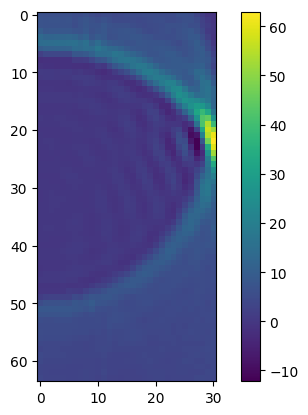

In [10]:
reconst_img = sound_localisation(mic_output, dist_per_samp, pitch)
plt.imshow(reconst_img, cmap="viridis")
plt.colorbar()

In [11]:
pos = np.unravel_index(np.argmax(reconst_img), reconst_img.shape)
print(pos)

# Scale, and shift axis accordingly
pos[1] * dist_per_samp, (pos[0] - (Nmics // 2 - 0.5)) * pitch

(22, 30)


(3.0, -0.9500000000000001)

## Coordinate System:
- The y-axis is scaled by `pitch`, and shifted down, so that the origin is in between `Nmics/2 - 1` and `Nmics/2`. In this case, the origin is at 31.5.
- The x-axis begins from the leftmost point on the image, and the scale is `dist_per_sample`.

This means, that over here, the obstacle is located at `(30 * dist_per_sample, (22 - 31.5) * pitch)`. This corresponds to `(3, -0.95)`, which is very close to our obstacle's location.

# Loading from TXT

In [12]:
# Load mic data for multiple objects
mic_output_txt = np.loadtxt("rx3.txt")

In [13]:
Nmics, Nsamp = mic_output_txt.shape

src = (0, 0)
pitch = 0.1
dist_per_samp = 0.1
C = 2.0

mics_txt = []

assert Nmics % 2 == 0, "Number of mics must be even!"

# Calculate mic positions
for i in range(Nmics):
    mics_txt.append((0, pitch * (-Nmics // 2 + 0.5 + i)))

# Time array
t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)

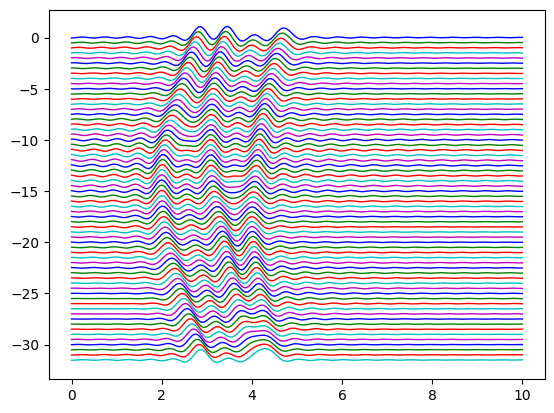

In [14]:
colors = "bgrcm"

# Waveforms received by each mic
for i in range(Nmics):
    plt.plot(t, mic_output_txt[i] - 0.5 * i, c=colors[i % len(colors)], linewidth=1)

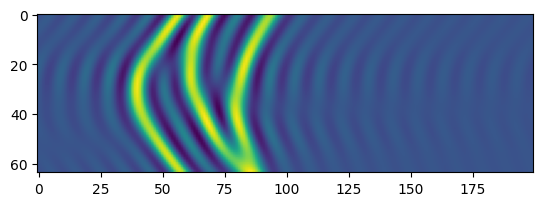

In [15]:
# Heatmap of mic data
plt.imshow(mic_output_txt, cmap="viridis")

In [16]:
def sound_localisation_multiple(mic_output, dist_per_samp, pitch):
    """
    Given the output recorded by a microphone, return a matrix indicating the obstacles' position.
    This works for multiple objects.
    """

    # Find out Nmics and Nsamp
    n_mics, n_samp = mic_output.shape

    # Calculate maximum t to go up to - this is the position of the furthest object.
    max_t = mic_output.argmax(axis=1).max() // 2 + 1
    reconst_img = np.zeros((n_mics, max_t))
    
    for x in range(max_t):
        for y in range(n_mics):
            for mic_ind, mic in enumerate(mics):
                # Calculate delay for sound to travel to pt and mic
                delay = round(dist(src, (dist_per_samp * x, pitch * (y - n_mics / 2 + 0.5)), mic) / dist_per_samp)

                # If that delay is within the captured time, sample it
                if delay < n_samp:
                    reconst_img[y, x] += mic_output[mic_ind][delay]

    return reconst_img

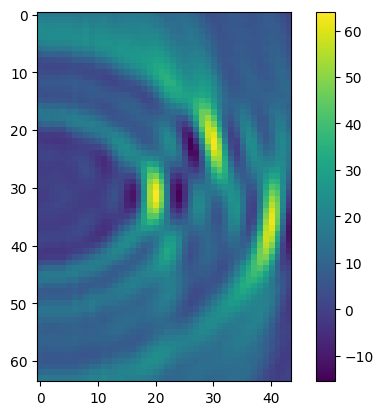

In [17]:
reconst_img_txt = sound_localisation_multiple(mic_output_txt, dist_per_samp, pitch)
plt.imshow(reconst_img_txt, cmap="viridis")
plt.colorbar()

In [18]:
def rescale(x: float, y: float) -> Tuple[float, float]:
    """Convert array indices to cartesian coordinates"""
    return y * dist_per_samp, (x - (Nmics // 2 - 0.5)) * pitch

print("Obstacles:", rescale(32, 20), rescale(24, 30), rescale(36, 40))

Obstacles: (2.0, 0.05) (3.0, -0.75) (4.0, 0.45)


# Why do there seem to be an arc for each obstacle?

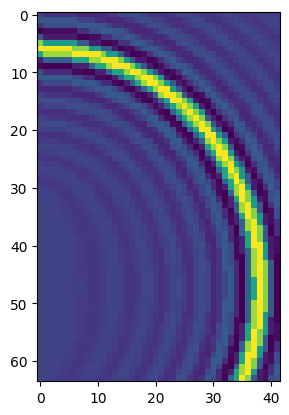

In [19]:
max_t = mic_output.argmax(axis=1).max() // 2 + 1
reconst_img_micwise = np.zeros((Nmics, max_t))

fig = plt.figure()
ims = []

# Build the heatmap mic-wise, so we can animate it
for mic_ind, mic in enumerate(mics):
    for x in range(max_t):
        for y in range(Nmics):
            # Calculate travel delay for each point
            delay = round(dist(src, (dist_per_samp * x, pitch * (y - Nmics / 2 + 0.5)), mic) / dist_per_samp)
            if delay < Nsamp:
                # Sample at that time delay
                reconst_img_micwise[y, x] = mic_output[mic_ind][delay]
    
    im = plt.imshow(reconst_img_micwise)
    ims.append([im])

In [20]:
from IPython.display import HTML

ani = ArtistAnimation(fig, ims,  blit=True, interval=50, repeat=True)
HTML(ani.to_jshtml(default_mode="reflect"))

Plotting the heatmap for each mic results in a circular pattern - the equation for this, in polar coordinates, would be `f(r, theta) = sinc(r)`. This circle is centered at the mic - so this results in a shifting circle. This is what causes the blend of arcs in the figure.

# DAS With an Arbitrary Signal

In [21]:
Nmics = 64
Nsamp = 200

src = (0, 0)

pitch = 0.1
dist_per_samp = 0.1
C = 2.0
SincP = 5.0

obstacle = (3, -1)

In [22]:
mics = []

assert Nmics % 2 == 0, "Number of mics must be even!"

# Calculate mics again
for i in range(Nmics):
    mics.append((0, pitch * (-Nmics // 2 + 0.5 + i)))

In [23]:
# Time array
t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)

# Sinusoidal signal - there is no single peak
def sin_wsrc(t):
    return np.sin(SincP * t)

In [24]:
# Calculate output received by mics
# I include some random noise as well

mic_output = np.zeros((Nmics, Nsamp))

for mic in range(Nmics):
    mic_output[mic] = sin_wsrc(t - dist(src, obstacle, mics[mic]) / C) + np.random.normal(0, 0.1, Nsamp)

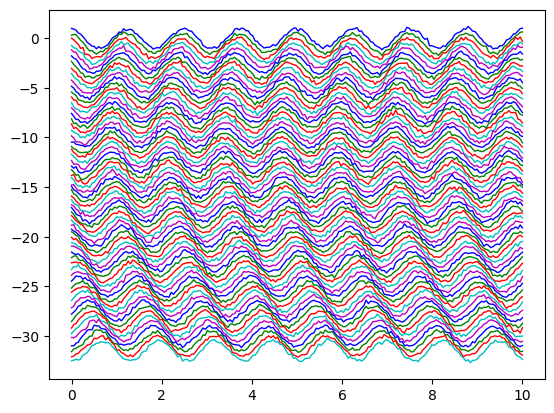

In [25]:
colors = "bgrcm"

for i in range(Nmics):
    plt.plot(t, mic_output[i] - 0.5 * i, c=colors[i % len(colors)], linewidth=1)

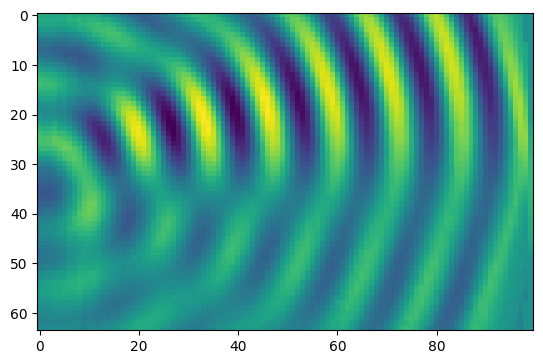

In [26]:
reconst_img = sound_localisation_multiple(mic_output, dist_per_samp, pitch)
plt.imshow(reconst_img, cmap="viridis")

While DAS works here, we cannot calculate the exact position, only the general direction. This is because there is no single peak for a sinusoidal wave, so we cannot pinpoint the obstacle location.

# Varying Nmics and Nsamp

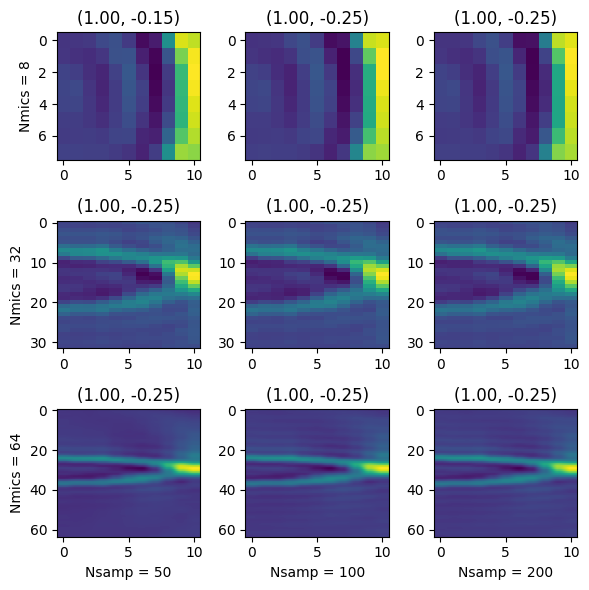

In [27]:
obstacle = (1, -0.25)

nmics_arr = [8, 32, 64]
nsamp_arr = [50, 100, 200]

fig, axs = plt.subplots(3, 3, figsize=(6, 6))

for idx_x, Nmics in enumerate(nmics_arr):
    # Calculate mic position
    mics = []
    for i in range(Nmics):
        mics.append((0, pitch * (-Nmics // 2 + 0.5 + i)))
    
    for idx_y, Nsamp in enumerate(nsamp_arr):
        # Generate time array
        t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)

        # Generate mic outputs with time delays
        mic_output = np.zeros((Nmics, Nsamp))
        for mic in range(Nmics):
            mic_output[mic] = wsrc(t - dist(src, obstacle, mics[mic]) / C)

        # Generate heatmap for obstacle position
        reconst_img = sound_localisation(mic_output, dist_per_samp, pitch)

        # Calculate object position
        pos = np.unravel_index(np.argmax(reconst_img), reconst_img.shape)
        obstacle_loc = pos[1] * dist_per_samp, (pos[0] - (Nmics // 2 - 0.5)) * pitch

        img = axs[idx_x, idx_y].imshow(reconst_img, cmap="viridis", aspect="auto")
        
        if idx_x == 2:
            axs[idx_x, idx_y].set_xlabel(f"Nsamp = {Nsamp}")
        if idx_y == 0:
            axs[idx_x, idx_y].set_ylabel(f"Nmics = {Nmics}")

        axs[idx_y, idx_x].set_title(f"({obstacle_loc[0]:.2f}, {obstacle_loc[1]:.2f})")

plt.tight_layout()

# Changing the Sinc Width

In [28]:
Nmics = 64
Nsamp = 200

src = (0, 0)

pitch = 0.1
dist_per_samp = 0.1
C = 2.0
SincP = 5.0

obstacle = (3, -1)

mics = []

assert Nmics % 2 == 0, "Number of mics must be even!"

for i in range(Nmics):
    mics.append((0, pitch * (-Nmics // 2 + 0.5 + i)))

t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)
def sin_wsrc(t):
    return np.sin(SincP * t)

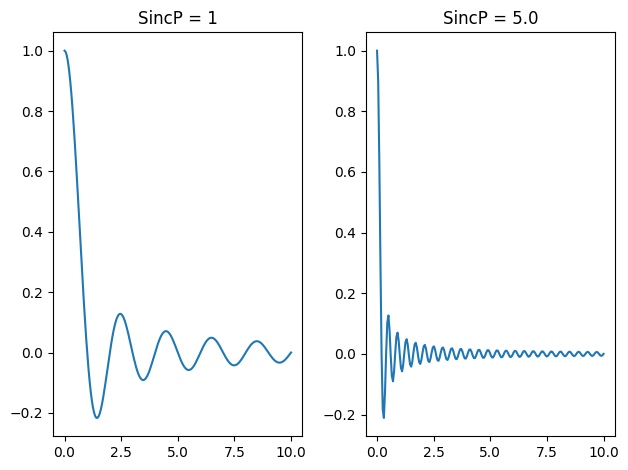

In [29]:
# We can vary the sinc width by changing one of C, dist_per_samp, or SincP
# Here, I compare SincP = 1 and SincP = 5

t = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)
wave_1 = np.sinc(t)
wave_2 = np.sinc(t * SincP)

fig, axs = plt.subplots(1, 2)
axs[0].plot(t, wave_1)
axs[0].set_title("SincP = 1")
axs[1].plot(t, wave_2)
axs[1].set_title(f"SincP = {SincP}")

plt.tight_layout()

# Changing the Value of C

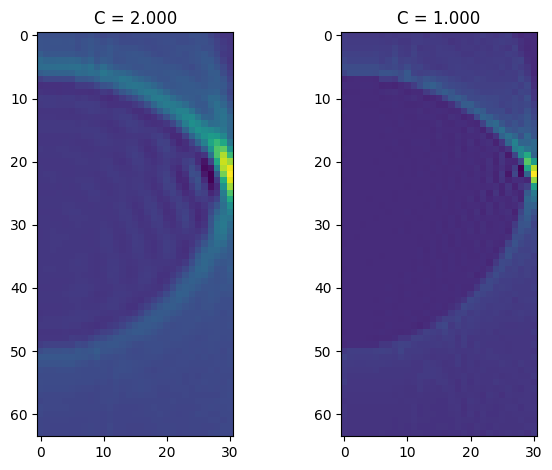

In [30]:
obstacle = (3, -1)

# Mic outputs for two different values of C
mic_output_C = np.zeros((Nmics, Nsamp))
mic_output_C2 = np.zeros((Nmics, Nsamp))

C = 2
C2 = C / 2

# Time arrays for two different values of C
t_C = np.linspace(0, Nsamp * dist_per_samp / C, Nsamp)
t_C2 = np.linspace(0, Nsamp * dist_per_samp / C2, Nsamp)

# Shift output for each mic
for mic in range(Nmics):
    mic_output_C[mic] = wsrc(t_C - dist(src, obstacle, mics[mic]) / C)
    mic_output_C2[mic] = wsrc(t_C2 - dist(src, obstacle, mics[mic]) / C2)

# Plot the output heatmaps
fig, axs = plt.subplots(1, 2)
axs[0].imshow(sound_localisation(mic_output_C, dist_per_samp, pitch), cmap="viridis")
axs[0].set_title(f"C = {C:.3f}")
axs[1].imshow(sound_localisation(mic_output_C2, dist_per_samp, pitch), cmap="viridis")
axs[1].set_title(f"C = {C2:.3f}")

plt.tight_layout()

Reducing C increases the sharpness of the image. This is because when C decreases, the width of the sinc pulse decreases - so the maxima decays much faster